In [12]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
from matplotlib import pyplot as plt

from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score  
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Music Genre Classifier by Multinomial Logistic Regression

In [13]:
# Load the dataset
df = pd.read_csv("features_30_sec.csv")
# print(df.head)

# Filter for the genres of interest
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# filters the DataFrame df to include only the rows where the values in the filename (head) match any of the values in the list genres that way we can train
# each genre seperately
df = df[df['label'].isin(genres)]

# Split the dataset into features (X) and target (y), then into training and test sets
X = df.drop(['filename', 'label'], axis=1)  # Drop non-numeric columns
y = df['label']

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000) # we keep some of the data for training and the rest goes to testing.

# print(X_train.head)

In [14]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Softmax Function
Note: will need multinomial logistic regression for this https://www.youtube.com/watch?v=Mi992wr6zKc&ab_channel=GopalPrasadMalakar

In [15]:
# soft max function generalizes sigmoid function for multiple classes (jazz rock pop blues etc instead of being just 1 or 0 for one genre)
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

### Multinomial Logistic Regression

In [16]:
class MultinomialLogisticRegression():
    # constructor
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr # learning rate
        self.n_iters = n_iters # number of iterations for the gradient descent loop
        self.weights = None # we dont know how much each factor weighs in to determining what genre it is so we initialize as none
        self.bias = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape # X.shape returns a tuple representing the dimensions of X
        self.classes_ = np.unique(y) 
        n_classes = len(self.classes_) # how many different genres we have
        
        self.weights = np.zeros((n_classes, n_features))
        self.bias = np.zeros(n_classes)
        
        y_encoded = self._one_hot(y) # converts the categorical genre labels into a binary matrix. e.g.(rock, pop, jazz)->[1, 0, 0]
        
        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights.T) + self.bias
            y_pred = softmax(linear_pred)
            
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y_encoded))
            db = (1/n_samples) * np.sum(y_pred - y_encoded, axis=0)
            
            self.weights -= self.lr * dw.T
            self.bias -= self.lr * db
    
    def predict(self, X):
        linear_pred = np.dot(X, self.weights.T) + self.bias
        y_pred = softmax(linear_pred)
        return np.argmax(y_pred, axis=1)
    
    def _one_hot(self, y):
        y_encoded = np.zeros((len(y), len(self.classes_)))
        for idx, label in enumerate(self.classes_):
            y_encoded[np.where(y == label), idx] = 1
        return y_encoded

$X$ (Input Matrix): This is a matrix where each row represents a data sample and each column represents a feature. If you have $n_{samples}$ data points and $n_{features}$ features, the dimension of $X$ would be $n_{samples} \times n_{features}$.

Weights: This is a vector with a length equal to the number of features ($n_{features}$). Its dimension is $n_{features} \times 1.$

Gradient descent is not calculating the coefficients of the sigmoid function but adjusting the weights $w_i$ and bias $b$ that are used within the linear combination fed into the sigmoid function. 

In [17]:
# Initialize and train the model
model = MultinomialLogisticRegression(lr=0.01, n_iters=1000)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Convert numeric predictions back to string labels
label_mapping = {idx: label for idx, label in enumerate(model.classes_)}
string_predictions = [label_mapping[label] for label in predictions]

# Evaluate the model
print(confusion_matrix(y_test, string_predictions))
print(classification_report(y_test, string_predictions))

[[10  1  1  0  0  2  0  0  0  0]
 [ 0 17  1  0  0  1  0  0  0  0]
 [ 3  1 13  1  0  1  0  2  0  3]
 [ 1  0  0  9  5  0  1  1  2  4]
 [ 0  0  0  0  9  1  1  0  3  0]
 [ 1  4  0  1  0 20  0  2  1  0]
 [ 1  0  0  1  0  0 15  0  0  1]
 [ 0  0  0  0  0  0  0 18  2  1]
 [ 1  0  1  0  4  0  0  1 17  0]
 [ 4  0  0  1  1  1  3  0  0  4]]
              precision    recall  f1-score   support

       blues       0.48      0.71      0.57        14
   classical       0.74      0.89      0.81        19
     country       0.81      0.54      0.65        24
       disco       0.69      0.39      0.50        23
      hiphop       0.47      0.64      0.55        14
        jazz       0.77      0.69      0.73        29
       metal       0.75      0.83      0.79        18
         pop       0.75      0.86      0.80        21
      reggae       0.68      0.71      0.69        24
        rock       0.31      0.29      0.30        14

    accuracy                           0.66       200
   macro avg       

## Accuracy Of Using Multinomial Logistic Regression
The objective of this section is to compare the test accuracy and training accuracy of Multinomial Logistic Regression with other methods including XGBoost and Neural Network.

In [18]:
music_data = pd.read_csv("features_30_sec.csv") 

# converting the categorical labels into numerical labels, 0-9
music_data['label'] = preprocessing.LabelEncoder().fit_transform(music_data['label'])

# dropping label & filename since it won't be used in our model
x = music_data.drop(['label','filename'], axis=1) # axis=1 means column
y = music_data['label']

# store all column names of x
cols = x.columns 

# each col of data -> seperate array
np_scaled = preprocessing.MinMaxScaler().fit_transform(x) 

# new data frame with the new scaled data. 
x = pd.DataFrame(np_scaled, columns=cols)

# test_size=0.2 means that 20% of data will be used for testing, and 80% for training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)

### Multinomial Logistic Regression

In [19]:
# initialize the Logistic Regression classifier
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# trains the Logistic Regression classifier on the training data
lr.fit(x_train, y_train)

# after training the classifier, it makes predictions on the test dataset
lr_preds = lr.predict(x_test)

print("Logistic Regression:", accuracy_score(lr_preds, y_test))

Logistic Regression: 0.7


### XGBoost

In [20]:
num_classes = len(set(y_train))

# initialize the XGB
xgb = XGBClassifier(num_class=num_classes, n_estimators=150, learning_rate=0.1)

# trains XGB on the training data
xgb.fit(x_train, y_train)

# after training the classifier, it makes predictions on the test dataset
xgb_preds = xgb.predict(x_test)

# Evaluate the model's accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))

XGBoost Accuracy: 0.78


### Neural Network

In [21]:
num_classes = len(set(y_train))

# creates a sequential model, which allows you to build a neural network one layer at a time
model = Sequential()


model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))  
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # num_classes is the number of classes

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# one-hot encode the target labels
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

model.fit(x_train, y_train_onehot, epochs=100, batch_size=32, validation_data=(x_test, y_test_onehot), verbose=0)

print("Neural Network Accuracy:", model.evaluate(x_test, y_test_onehot, verbose=0)[1])

Neural Network Accuracy: 0.7649999856948853


### Comparision of Accuracy for Different Methods

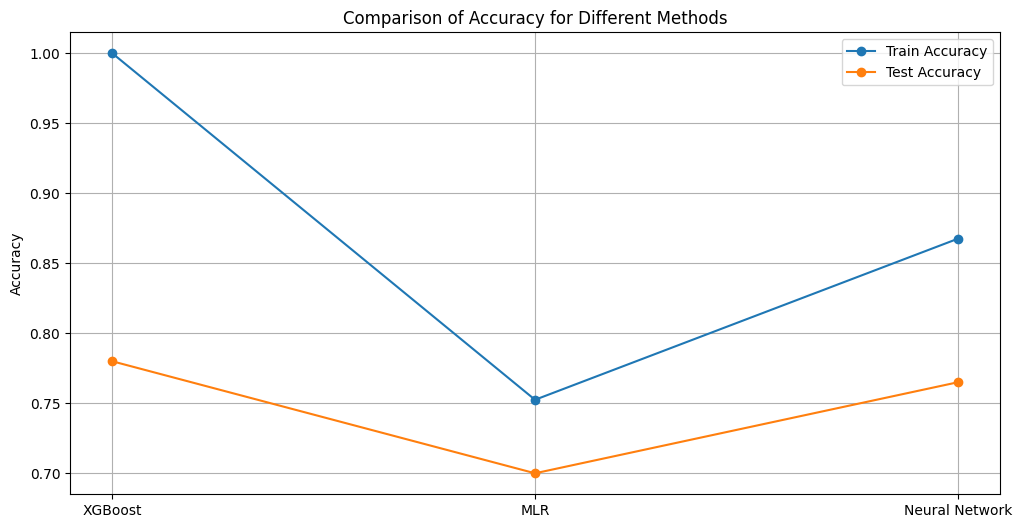

In [22]:
xgb_train_preds = xgb.predict(x_train)
xgb_test_preds = xgb.predict(x_test)
xgb_train_accuracy = accuracy_score(y_train, xgb_train_preds)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)


lr_train_preds = lr.predict(x_train)
lr_test_preds = lr.predict(x_test)
lr_train_accuracy = accuracy_score(y_train, lr_train_preds)
lr_test_accuracy = accuracy_score(y_test, lr_test_preds)


nn_train_accuracy = model.evaluate(x_train, y_train_onehot, verbose=0)[1]
nn_test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)[1]

## plot the accuracy comparison
methods = ['XGBoost', 'MLR', 'Neural Network']
train_accuracies = [xgb_train_accuracy, lr_train_accuracy, nn_train_accuracy]
test_accuracies = [xgb_test_accuracy, lr_test_accuracy, nn_test_accuracy]

plt.figure(figsize=(12, 6))
plt.plot(methods, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(methods, test_accuracies, label='Test Accuracy', marker='o')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy for Different Methods')
plt.legend()
plt.grid(True)
plt.show()


### Why MLR might not be the best choice ?
Multinomial Logistic Regression (MLR) may not be as accurate as XGBoost and Neural Networks in certain situations due to its inherent limitations:
- MLR assumes linear relationships between the input features and the target classes. In cases where the underlying relationships are highly non-linear, MLR may not capture complex patterns in the data. XGBoost and Neural Networks can model non-linear relationships much more effectively.
- MLR may struggle with very large datasets or highly complex data. In contrast, XGBoost and Neural Networks can be scaled and adapted to accommodate
- XGBoost and Neural Networks offer more hyperparameter tuning flexibility, allowing fine-tuning of the model's performance. MLR has fewer hyperparameters to adjust

So, the choice of method depends on the nature of the problem, the quality and quantity of data, the trade-off between model complexity and interpretability, and the available computational resources. Multinomial Logistic Regression (MLR) can be a suitable option for relatively simple classification tasks with linearly separable classes and a requirement for interpretability. However, for tasks that involve complex relationships or require high predictive accuracy, MLR might not be the best choice.